In [217]:
NUMBER_OF_EPOCH = 50000

In [218]:
import torch
import torch.nn as nn
import pandas as pd
import preprossesing as pre
import math
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")
    

tensor([1.], device='mps:0')


In [219]:
def prepare_model(df):
    
    df = pre.standardize(df)
    df = pre.encoder(df)
    df = df.drop(['id'], axis=1)

    train, val = pre.test_validation_split(df)
    
    y_train = torch.tensor(train['price'].values, dtype=torch.float32)
    X_train = train.drop(['price'], axis=1)
    X_train = torch.tensor(X_train.values, dtype=torch.float32)
    
    y_val = torch.tensor(val['price'].values, dtype=torch.float32)
    X_val = val.drop(['price'], axis=1)
    X_val = torch.tensor(X_val.values, dtype=torch.float32)
    
    return X_train, y_train, X_val, y_val

In [220]:
# Define model
class mlp(nn.Module):
    def __init__(self):
        super(mlp, self).__init__()
        
        self.layers = nn.Sequential(
        nn.Linear(9, 64),
        nn.ReLU(), 
        
        nn.Linear(64, 32),
        nn.ReLU(), 
        
        nn.Linear(32, 16),
        nn.ReLU(),
        
        nn.Linear(16, 1) 
        )
        
        self.manufacturers = nn.Sequential(
        nn.Linear(9, 1),
        nn.ReLU()
        )
        
        self.model = nn.Sequential(
        nn.Linear(143, 1),
        nn.ReLU()
        )
        
        self.gearbox_type = nn.Sequential(
        nn.Linear(3, 1),
        nn.ReLU()
        )
        
        self.fuel_type = nn.Sequential(
        nn.Linear(4, 1),
        nn.ReLU()
        )
        
        self.registration_fees = nn.Sequential(
        nn.Linear(12, 1),
        nn.ReLU()
        )
        
        self.engine_capacity = nn.Sequential(
        nn.Linear(15, 1),
        nn.ReLU()
        )
        
    def forward(self, x):
        manufacutre_output = self.manufacturers(x[:, 3:12])
        model_output = self.model(x[:, 12:155])
        gearbox_output = self.gearbox_type(x[:, 155:158])
        fuel_output = self.fuel_type(x[:, 158:162])
        registration_fees_output = self.registration_fees(x[:, 162:174])
        engine_capacity_output = self.engine_capacity(x[:, 174:189])
        x = torch.cat((x[:, :3], manufacutre_output, model_output, gearbox_output, fuel_output, registration_fees_output, engine_capacity_output), 1)

        return self.layers(x)

model = mlp()
model

mlp(
  (layers): Sequential(
    (0): Linear(in_features=9, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
  (manufacturers): Sequential(
    (0): Linear(in_features=9, out_features=1, bias=True)
    (1): ReLU()
  )
  (model): Sequential(
    (0): Linear(in_features=143, out_features=1, bias=True)
    (1): ReLU()
  )
  (gearbox_type): Sequential(
    (0): Linear(in_features=3, out_features=1, bias=True)
    (1): ReLU()
  )
  (fuel_type): Sequential(
    (0): Linear(in_features=4, out_features=1, bias=True)
    (1): ReLU()
  )
  (registration_fees): Sequential(
    (0): Linear(in_features=12, out_features=1, bias=True)
    (1): ReLU()
  )
  (engine_capacity): Sequential(
    (0): Linear(in_features=15, out_features=1, bias=True)
    (1): ReLU()
  )
)

In [221]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))

In [222]:
loss_fn = RMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [223]:
df = pd.read_csv('data/train.csv')
X_train, y_train, X_val, y_val = prepare_model(df)

In [224]:
import numpy as np
best_val_loss = float('inf')
training_loss = np.array([])
validation_loss = np.array([])
last_val_loss = float('inf')
count = 0

for n in range(NUMBER_OF_EPOCH):
    model.train()
    y_pred = model(X_train)[:, 0]
    loss = loss_fn(y_pred, y_train)
    training_loss = np.append(training_loss, loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model.eval()
    y_pred = model(X_val)[:, 0]
    val_loss = loss_fn(y_pred, y_val)
    validation_loss = np.append(validation_loss, val_loss.item())
    if val_loss < best_val_loss:
        best_val_loss = val_loss
    
    torch.save(model, 'mlp_model.pth')
    
    if n % 100 == 0:
        print(f'Epoch: {n} Loss: {loss.item()}'f' Validation loss: {val_loss.item()}'f' best Validation loss: {best_val_loss}')
        
    if last_val_loss < val_loss:
        count += 1
        if count == 50:
            break
    else:
        count = 0
    last_val_loss = val_loss
    

Epoch: 0 Loss: 19160.572265625 Validation loss: 19022.7265625 best Validation loss: 19022.7265625
Epoch: 100 Loss: 19126.24609375 Validation loss: 18986.7734375 best Validation loss: 18986.7734375
Epoch: 200 Loss: 17711.236328125 Validation loss: 17527.416015625 best Validation loss: 17527.416015625
Epoch: 300 Loss: 7585.12841796875 Validation loss: 7479.57666015625 best Validation loss: 7479.57666015625
Epoch: 400 Loss: 5974.44482421875 Validation loss: 5888.576171875 best Validation loss: 5888.576171875
Epoch: 500 Loss: 5062.52294921875 Validation loss: 4964.53271484375 best Validation loss: 4964.53271484375
Epoch: 600 Loss: 4541.85986328125 Validation loss: 4436.80712890625 best Validation loss: 4436.80712890625
Epoch: 700 Loss: 4224.8447265625 Validation loss: 4114.0576171875 best Validation loss: 4114.0576171875
Epoch: 800 Loss: 3973.368408203125 Validation loss: 3856.96923828125 best Validation loss: 3856.96923828125
Epoch: 900 Loss: 3747.6904296875 Validation loss: 3628.10693359

(50000,) (50000,)


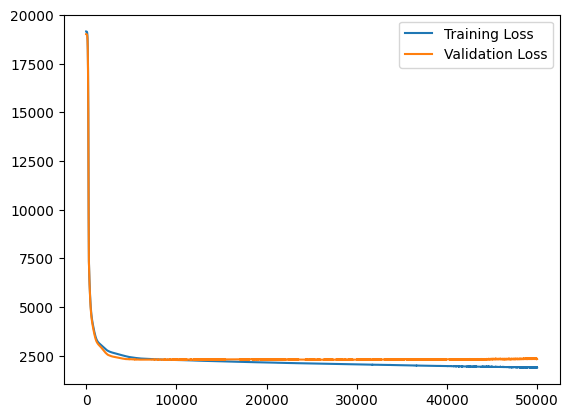

In [225]:
import matplotlib.pyplot as plt

print(training_loss.shape, validation_loss.shape)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.legend(loc='best')

In [226]:
import pickle

df = pd.read_csv('data/test.csv')
model = torch.load('mlp_model.pth')
model.eval()

index = df['id']
df = df.drop(['id'], axis=1)
X = pre.encoder(df)
X = pre.standardize(X, scaler=pickle.load(open('scaler.pkl', 'rb')))
X = torch.tensor(X.values, dtype=torch.float32)
y_pred = model(X)[:, 0]

df = pd.DataFrame(y_pred.detach().numpy(), columns=['price'])
df = pd.concat([index, df], axis=1)
df.rename(columns={'price': 'answer'}, inplace=True)
df.to_csv('output.csv', index=False)

/var/folders/64/cy9kvd894_bfkfb71dsbxt2w0000gn/T/ipykernel_61623/228361571.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('mlp_model.pth')
